# <p style="text-align: center">NBA 2019年度最有價值球員預測分析</p>



In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import psutil, sys, gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import warnings
import pydotplus
from scipy import stats
from IPython.display import display, HTML, Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection  import GridSearchCV
from sklearn.tree import export_graphviz
warnings.filterwarnings('ignore') # "error", "ignore", "always", "default", "module" or "once"
# Free Memory
# (1) 獲取物件及其大小的排序列表 
# (2) 將刪除的物件所佔的記憶體釋放
def memoryClean(dirList):
    print('Total Process Memory Usages: %s' %psutil.Process().memory_info().rss)
    print('Memory Usage Statistics: %s' %str(psutil.virtual_memory()))
    reserved_vars = ['In', 'Out', 'exit', 'quit', 'ipython_vars', 'sys', 'os'
                     'gc', 'IODataDir', 'side_by_side', 'memoryClean', 'np',
                     'pd', 'plt','sns', 'mlab', 'display', 'HTML', 'psutil']
    # Display Memory Usage
    # sorted([(x, sys.getsizeof(globals().get(x))) for x in dir()
            # if not x.startswith('_') and
            # x not in sys.modules and
            # x not in ipython_vars],key=lambda x: x[1], reverse=True)
    for name in dirList:
        if not name.startswith('_') and name not in sys.modules and name not in reserved_vars:
            del globals()[name]
    gc.collect()

# 定義函數以便執行肩並肩的列印
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

def chinese():
    import platform
    if platform.system() == 'Windows':
        # plt.rcParams['font.sans-serif'] = ['SimHei'] # 步驟一（替換sans-serif字型）
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
        plt.rcParams['axes.unicode_minus'] = False  # 步驟二（解決座標軸負數的負號顯示問題）
    else:
        # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
        # mpl.rcParams['font.family'] = ['Heiti TC']
        plt.rcParams['font.family'] = ['Heiti TC']

# Create a Working Directory
IODataDir = "./Data_and_Images/Feature_Sel_Extract/"
import os
if not os.path.exists(IODataDir):
    os.makedirs(IODataDir)

In [2]:
# setting params
params = {'legend.fontsize': 'x-large','figure.figsize': (30, 10),
         'axes.labelsize': 'x-large', 'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set_style('whitegrid')
%matplotlib inline

## 本章目錄 (Github上無法使用)

* [1. 研究動機](#1.-研究動機)
* [2. 期望成果](#2.-期望成果)
* [3. 資料來源](#3.-資料來源)
* [4. 數據介紹](#4.-數據介紹)
* [5. 模型選擇](#5.-模型選擇)
* [6. 參考資料](#6.-參考資料)
* [7. 資料整理](#7.-資料整理)
* [8. 資料圖像化](#8.-資料圖像化)
* [9. 分層抽樣](#9.-分層抽樣)
* [10. 特徵重要度](#10.-特徵重要度)
* [11. 訓練模型](#11.-訓練模型)
* [12. 預測結果](#12.-預測結果)

## 1. 研究動機  
   籃球運動在全世界都有許多愛好者，談到籃球就必須提及國際籃球最高殿堂-美國國家籃球協會(National Basketbal Association)，也就是家喻戶曉的NBA，NBA從1955-1956年賽季開始頒發年度獎項-年度最有價值球員，表揚賽季中表現最優異的球員，早期賽季到1980年前，最有價值球員都是經NBA球員投票投出，1980年後改為美加兩國各地的體育記者和廣播員，共同投票選出每人可以選出心目中的前五名，每張選票上獲得得名次換算成分數如下：  
--第一名→10分  
--第二名→7分  
--第三名→5分  
--第四名→3分  
--第五名→1分  
   2010年起球迷甚至可以在網路上投票預測，這讓我們想試著利用往年的數據來作預測模型。  

[回本章目錄](#本章目錄)

## 2. 期望成果  

   在籃球賽季前或季後賽前，利用往年球員各項數據製作的模型，預測「年度最有價值球員(MVP)」。  
   這個分析可以幫助我們了解球員各項數據對於成為「最有價值球員」的影響程度。


<div>
    <img src="./Data and image/method.png" width="1000" style = "display: inline;float: left; margin-top: 10px; margin-left: 0px"/>
</div>
   
[回本章目錄](#本章目錄)

## 3. 資料來源  
##### kaggle-NBA MVP votings through history：https://www.kaggle.com/danchyy/nba-mvp-votings-through-history
   資料內容：637個(1980-2018)球員數據(其中包含當季MVP球員與當季MVP候補球員40個(2019)MVP候補球員數據
   重要數據介紹
   
   [回本章目錄](#本章目錄)

## 4. 數據介紹
- **fga** 投籃出手次數 (包括兩分球和三分球、不包括罰球)  
- **fg3a** 三分球出手次數  
- **fta** 罰球次數  
- **per** 球員進攻效率值  
- **ts_pct** 投籃命中率 PTS(得分) /（2 *（FGA + 0.44 * FTA））* 100  
- **usg_pct** 球權使用率  
- **Bpm** 每100回合的貢獻比聯盟平均等級的球員高多少  
- **Season** 賽季  
- **player** 球員姓名  
- **win_pct** 球隊的勝率 won/total  
- **votes_first** 第一名投票  
- **points_won** 得票分數  
- **points_max**  最高得票分數  
- **award_share points_won/points_max**  得票率  
- **g**  上場次數  
- **mp_per_g** 平均每場比賽上場分鐘數  
- **pts_per_g**  平均每場比賽得分  
- **trb_per_g** 平均每場比賽籃板  
- **ast_per_g** 平均每場比賽助攻  
- **stl_per_g** 平均每場比賽抄截  
- **blk_per_g** 平均每場比賽火鍋  
- **fg_pct** 投籃命中率(兩分球和三分球的整體命中率、不包括罰球)  
- **fg3_pct** 三分球命中率  
- **ft_pct** 罰球命中率  
- **ws** 勝利貢獻值 進攻勝利貢獻值+防禦貢獻值  
- **ws_per_48** 每48分鐘的勝率貢獻值 WS/球員的總上場時間*48  
  
### 其他註解    
- **per 球員進攻效率值**  
  加向(投籃命中數、罰球命中數、三分命中數、助攻、籃板、抄截、阻攻)  
  減項(投丟的次數、失誤數、犯規次數

<img src="./Data and image/PER.png" width="500" style = "display: block; margin-top: 0px; margin-left: 150px"/> 

- **usg_pct 球權使用率**  
  指的是一個球員終結了球隊多少比例的進攻機會  
  usg_pct = 100 * ((投籃次數 + 0.44 *罰球次數 + 失誤次數) * (球隊球員總出場時間/ 5)) / (該球員出場時間 * (球隊投籃總數 + 0.44 * 球隊罰球總數 + 球隊失誤總數))
- **Bpm表示每100回合的貢獻比聯盟平均等級的球員高多少**  
  根據得分、籃板率、助攻率、失誤率、球權占有率等等
  (聯盟平均BPM=0，BPM>5屬於全明星等級，BPM=-5則為非常差勁)
- **ws 勝利貢獻值**  
  進攻勝利貢獻值+防禦貢獻值、隨著比賽的進行而累計、當球隊輸球可能是負數

[回本章目錄](#本章目錄)

## 5. 模型選擇  
本次研究將使用隨機森林(Random Forest)製作模型，可以在訓練過程中，能夠檢測特徵間的重要度。

[回本章目錄](#本章目錄)

## 6. 參考資料  
Mvp介紹：https://zh.wikipedia.org/wiki/NBA%E6%9C%80%E6%9C%89%E4%BB%B7%E5%80%BC%E7%90%83%E5%91%98  
籃球數據解釋1：https://kknews.cc/sports/r5nxaxr.html  
籃球數據解釋2： https://kknews.cc/zh-tw/sports/59qlza3.html  
WS、bpm公式： https://www.sportsv.net/articles/45943  
per公式： https://www.sportsv.net/articles/45609  
Usg_pct公式：https://www.sportsv.net/articles/45527  
win_pct解釋：https://kknews.cc/zh-tw/sports/b2v6nan.html  
相依性解釋： https://www.ptt.cc/bbs/Spurs/M.1447258597.A.B08.html  


[回本章目錄](#本章目錄)

## 7. 資料整理

In [4]:
MVP_ALL = pd.read_csv("./mvp_all.csv")
side_by_side("MVP_ALL",MVP_ALL.shape, MVP_ALL.isnull().sum(), 
             MVP_ALL.count(), MVP_ALL.dtypes)

'MVP_ALL'    (677, 22)    fga          0    fga          677    fga          float64
                          fg3a         0    fg3a         677    fg3a         float64
                          fta          0    fta          677    fta          float64
                          per          0    per          677    per          float64
                          ts_pct       0    ts_pct       677    ts_pct       float64
                          usg_pct      0    usg_pct      677    usg_pct      float64
                          bpm          0    bpm          677    bpm          float64
                          season       0    season       677    season         int64
                          player       0    player       677    player        object
                          win_pct      0    win_pct      677    win_pct      float64
                          g            0    g            677    g              int64
                          mp_per_g     0    mp_per_g     677    m

### NULL值根據資料來源解釋因當賽季無此數據，因此標為0 (例如: 該球員未曾投過三分球)。

In [5]:
MVP_ALL['fg3_pct'] = MVP_ALL['fg3_pct'].fillna(0) 
MVP_ALL['MVP']=0
side_by_side("MVP_ALL",MVP_ALL.shape, MVP_ALL.isnull().sum(), 
             MVP_ALL.count(), MVP_ALL.dtypes)

'MVP_ALL'    (677, 23)    fga          0    fga          677    fga          float64
                          fg3a         0    fg3a         677    fg3a         float64
                          fta          0    fta          677    fta          float64
                          per          0    per          677    per          float64
                          ts_pct       0    ts_pct       677    ts_pct       float64
                          usg_pct      0    usg_pct      677    usg_pct      float64
                          bpm          0    bpm          677    bpm          float64
                          season       0    season       677    season         int64
                          player       0    player       677    player        object
                          win_pct      0    win_pct      677    win_pct      float64
                          g            0    g            677    g              int64
                          mp_per_g     0    mp_per_g     677    m

[回本章目錄](#本章目錄)

## 8. 資料圖像化

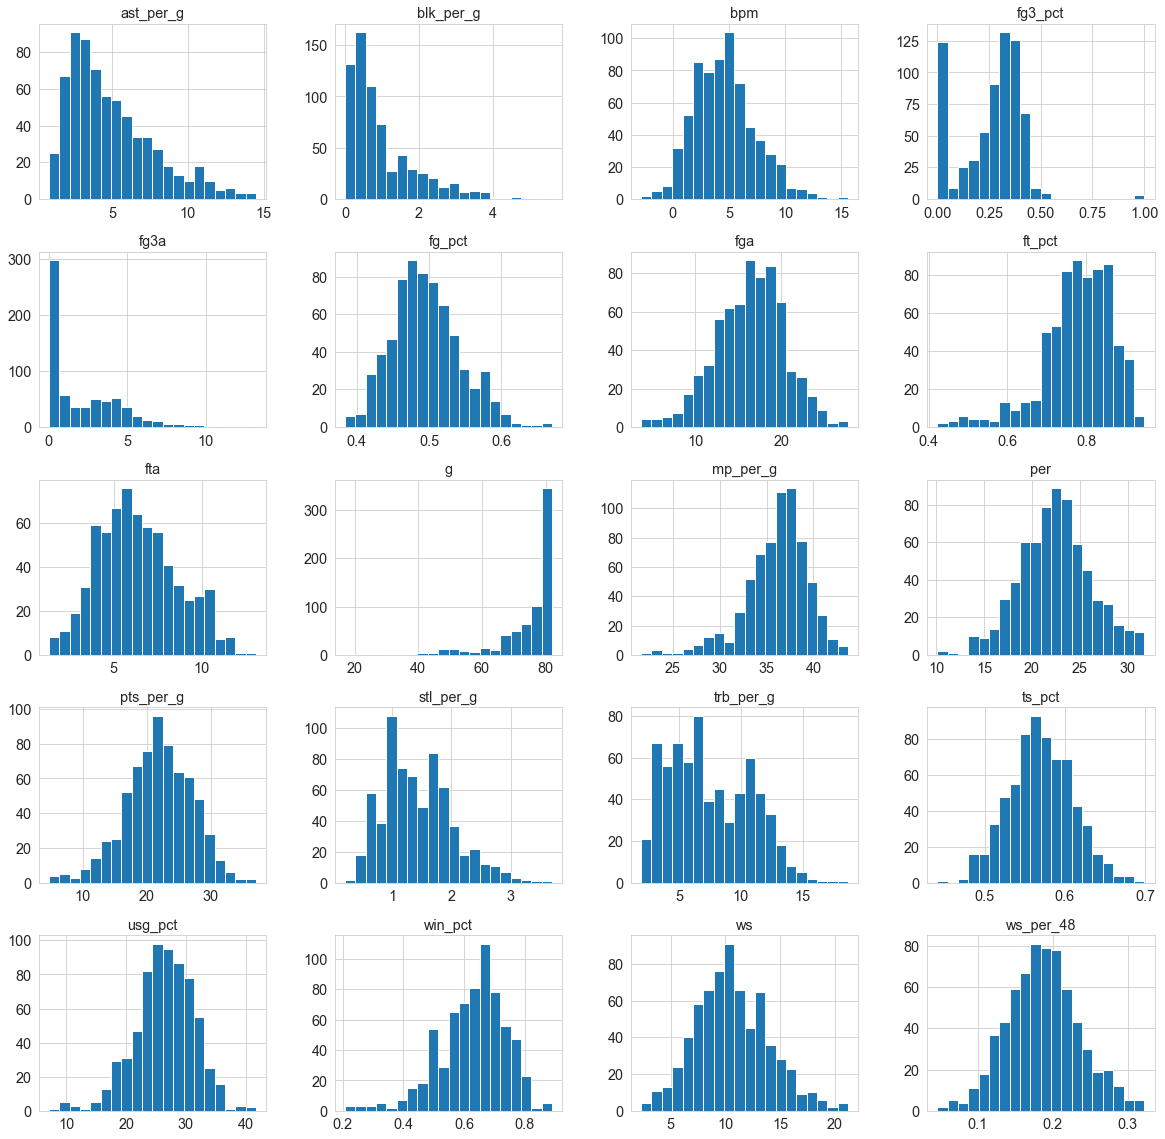

In [6]:
a = MVP_ALL.drop(['season', 'player','MVP'],axis=1)
a.hist(figsize=(20,20), bins=20);

#### 觀察上面格子中的長條圖，我們發覺數據大多集中於左邊和中間，除了像是g(上場次數)，因為資料都是當季MVP候選人，想當然爾出場次數肯定會較高。

[回本章目錄](#本章目錄)

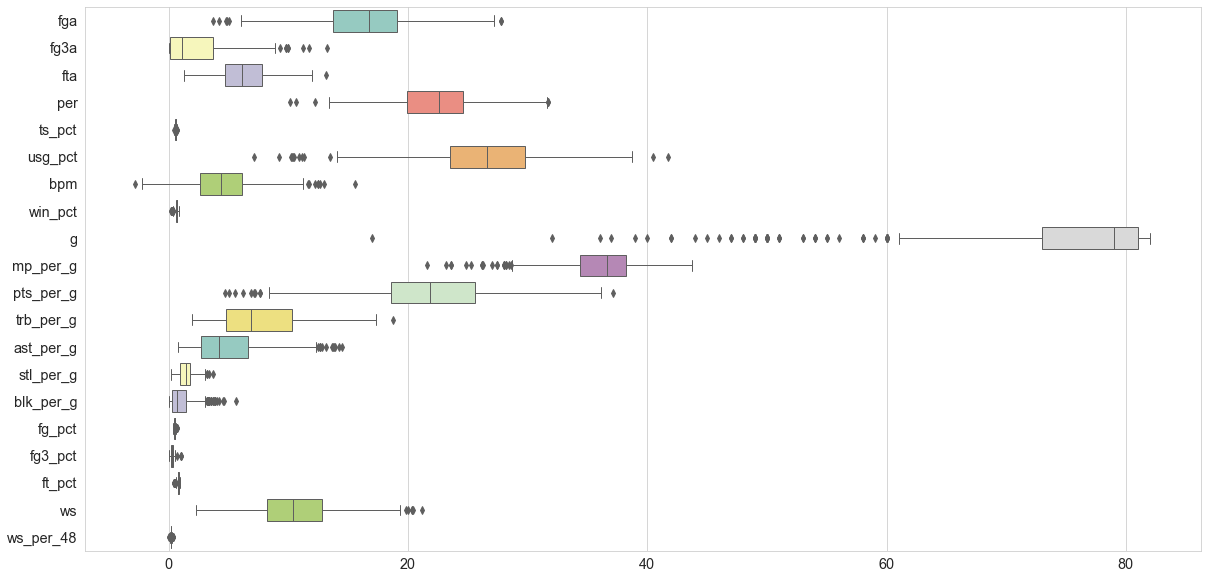

In [7]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(data=a, ax=ax1, orient= 'h', linewidth=1, palette="Set3");

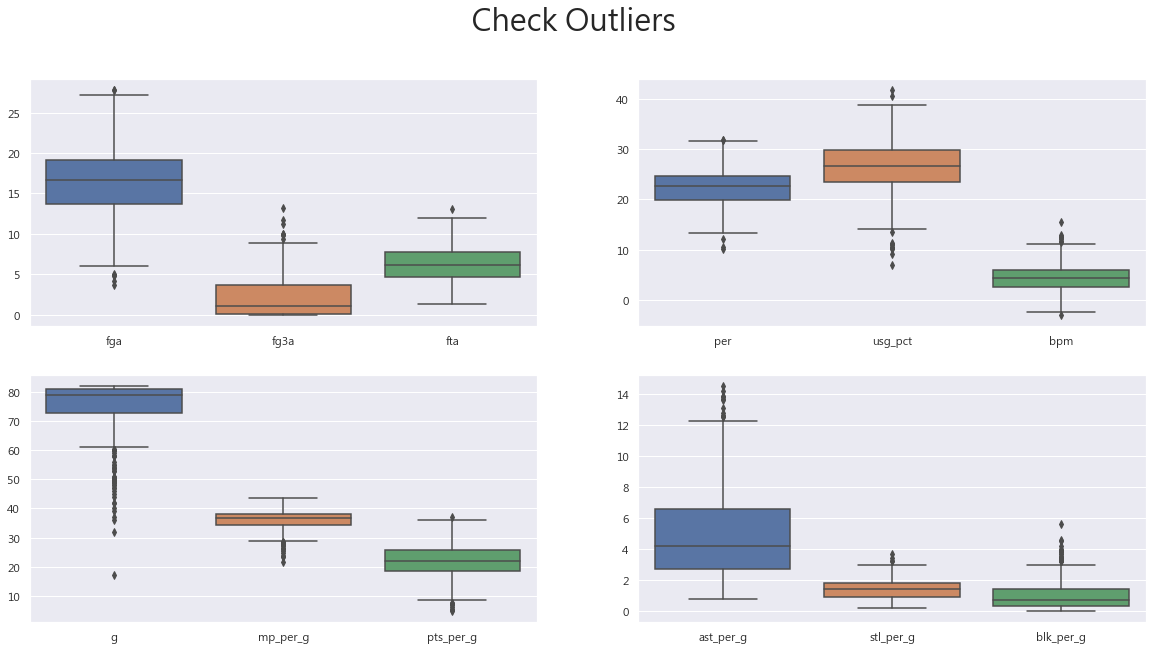

In [8]:
chinese()
fig,axs = plt.subplots(ncols=2,nrows=2, figsize=(20,10))
fig.suptitle(" Check Outliers", fontsize=30)
sns.boxplot(data=a[['fga', 'fg3a','fta']],ax=axs[0,0])
sns.boxplot(data=a[['per','usg_pct','bpm']],ax=axs[0,1])
sns.boxplot(data=a[['g','mp_per_g','pts_per_g']],ax=axs[1,0])
sns.boxplot(data=a[['ast_per_g','stl_per_g','blk_per_g']],ax=axs[1,1])

#### 觀察上面格子中的箱鬚圖、線箱圖，說明了此數據集有較多Outlier，但是MVP的數據本身就會較其他球員高而數據過低的球員本身就會被淘汰，所以這裡我們並不會將Outlier的數據做移除。

[回本章目錄](#本章目錄)

### 新增類別欄位，MVP設為1、非MVP設為0。

In [9]:
num = pd.unique(MVP_ALL.season)
c=0
for s in range(len(num)):
    a = MVP_ALL[(MVP_ALL.season==num[s])].index.tolist()
    for k in range(len(a)):
        if k == 0:
            MVP_ALL.MVP[c]=1
        c=c+1
side_by_side("MVP_ALL",MVP_ALL.shape, MVP_ALL.isnull().sum(), 
             MVP_ALL.count(), MVP_ALL.dtypes)

'MVP_ALL'    (677, 23)    fga          0    fga          677    fga          float64
                          fg3a         0    fg3a         677    fg3a         float64
                          fta          0    fta          677    fta          float64
                          per          0    per          677    per          float64
                          ts_pct       0    ts_pct       677    ts_pct       float64
                          usg_pct      0    usg_pct      677    usg_pct      float64
                          bpm          0    bpm          677    bpm          float64
                          season       0    season       677    season         int64
                          player       0    player       677    player        object
                          win_pct      0    win_pct      677    win_pct      float64
                          g            0    g            677    g              int64
                          mp_per_g     0    mp_per_g     677    m

## 9. 分層抽樣
- <font style='font-weight:bold;color:red'>因為38個賽季總共有637筆資料，也就是說有38個MVP與599個落選MVP球員，如果將資料全數訓練會造成數據不平衡，因此我們將資料每季為每一層，並從每一層抽取1個MVP球員與N個非MVP球員。</font>
- 從先前資料(1980-2018)拆分10次做為訓練資料與測試資料。
- 結合分層抽樣與10次交叉驗證將10次訓練精確度(precision)加總取平均值得到抽樣層數。
- 結合分層抽樣將10次訓練特徵重要度加總取平均值。

<img src="./Data and image/sampling.png" width="800"/>


[回本章目錄](#本章目錄)

### 每次更改抽樣數 n(3~8)

In [12]:
#在每個賽季分層抽樣1個MVP球員與N個非MVP球員
#1-28季為訓練資料29季為測試資料
#1-29季為訓練資料30季為測試資料
#1-30季為訓練資料31季為測試資料
#.....
#1-37季為訓練資料38季為測試資料
#共10次，並將10次精確度加總取平均值
pr=[]
feature= np.zeros( (10,20) )
for i in range(1, 11): #0-10  
    X_train = pd.DataFrame(columns=MVP_ALL.columns)
    X_final_train = pd.DataFrame(columns=MVP_ALL.columns)
    X_final_test = pd.DataFrame(columns=MVP_ALL.columns)
    for j in range(1, (28+i)):
        X_train = X_train.append(MVP_ALL[MVP_ALL.season==j])
        
    X_final_test = X_final_test.append(MVP_ALL[MVP_ALL.season==(j+1)])  

    n=8      # 設定 抽樣數
    rs=10    # 設定 random seed 
    num = pd.unique(X_train.season)
    for k in range(len(num)):
        M_num = X_train[(X_train.season==num[k])&(X_train.MVP==1)]
        n_num = X_train[(X_train.season==num[k])&(X_train.MVP==0)]
        test_index=n_num.sample(n,random_state=rs) 
        X_final_train = pd.concat([X_final_train,M_num])
        X_final_train = pd.concat([X_final_train,test_index])    
 
    Y_final_train = X_final_train.MVP.astype('int64')
    Y_final_test = X_final_test.MVP.astype('int64')
    X_final_train = X_final_train.drop(['season', 'player','MVP'],axis=1)
    X_final_test = X_final_test.drop(['season', 'player','MVP'],axis=1)
    
    RC = RandomForestClassifier(random_state=10,n_estimators = 100)  
    precision = cross_val_score(RC,X_final_train,Y_final_train,cv=10,scoring='precision')

    pr.append(precision.mean())
    
print("precision=",statistics.mean(pr))   

precision= 0.8075


- 使用分層抽樣與10次交叉驗證並將10次訓練精確度加總取平均值。
- 由下圖得知最佳抽樣比例為1:8

<img src="./Data and image/sampling_result.png" width="800" />


[回本章目錄](#本章目錄)

## 10. 特徵重要度
### 我們以1:8作為最佳抽樣比例，跟先前一樣將資料(1980-2018)拆分10次做為訓練資料與測試資料，最後將10次的特徵重要度做成曲線圖，並觀察特徵重要度的變化

accuracy= 0.9367254559166324 precision= 0.7662878787878787


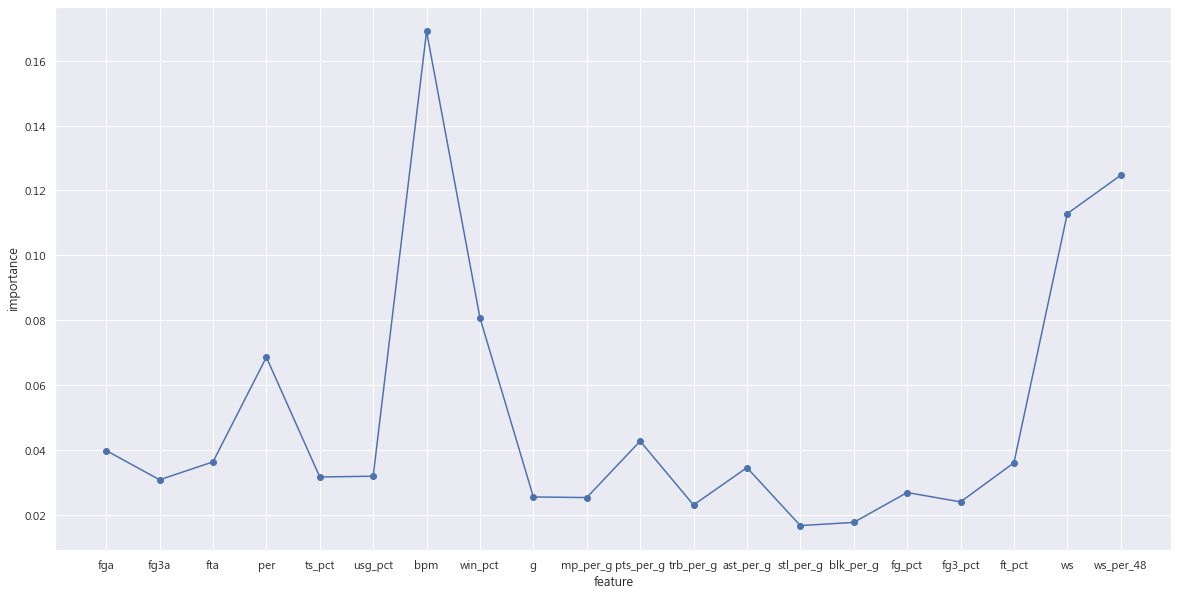

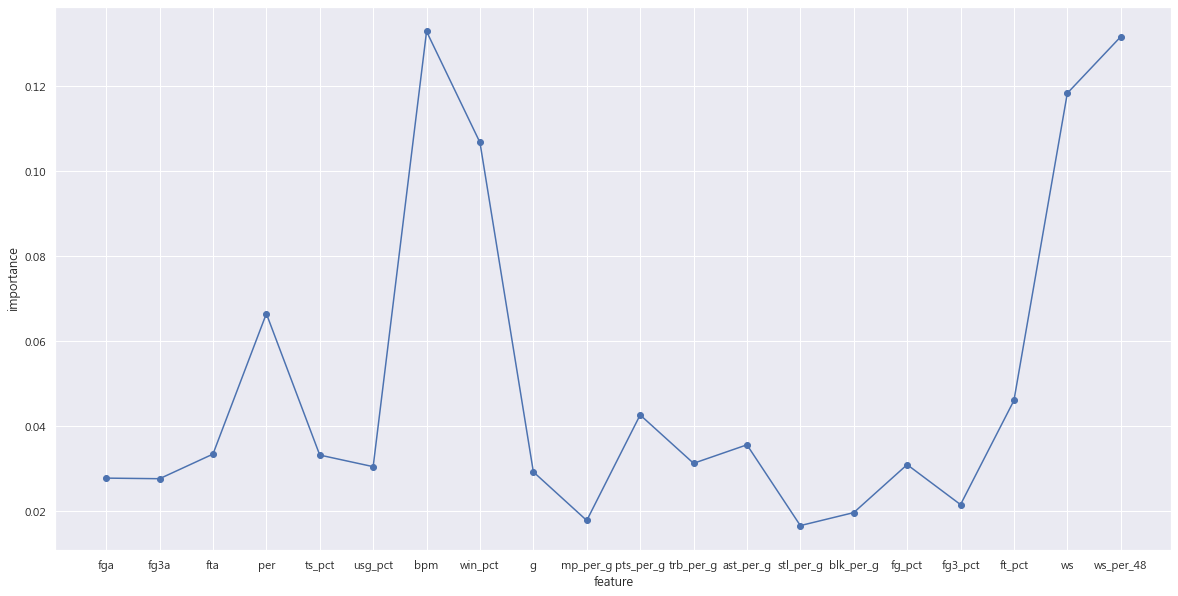

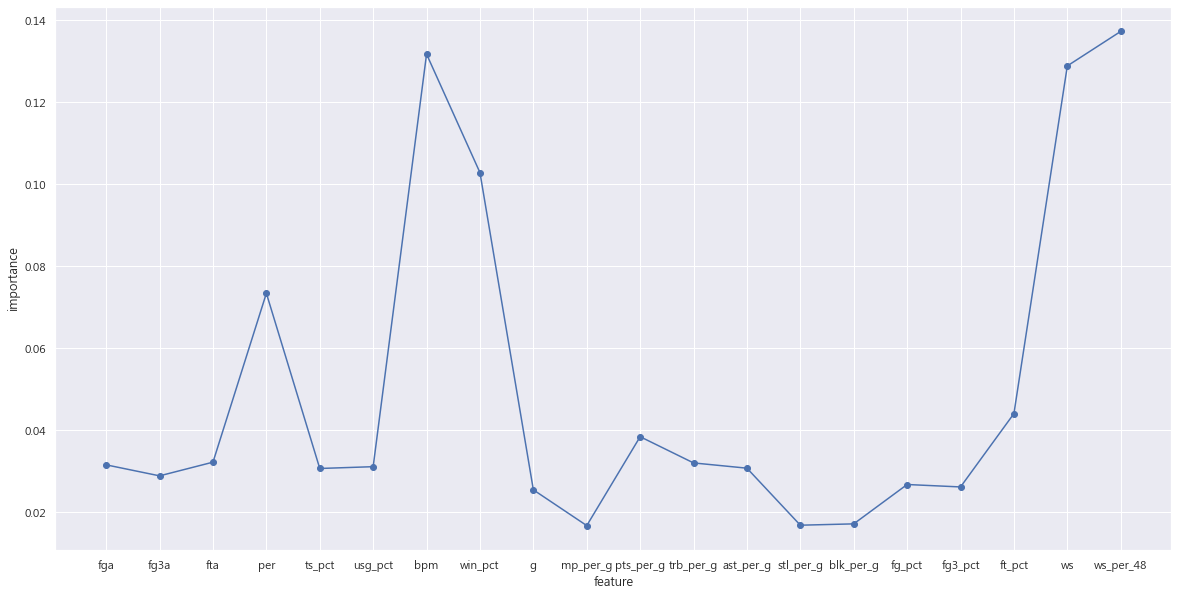

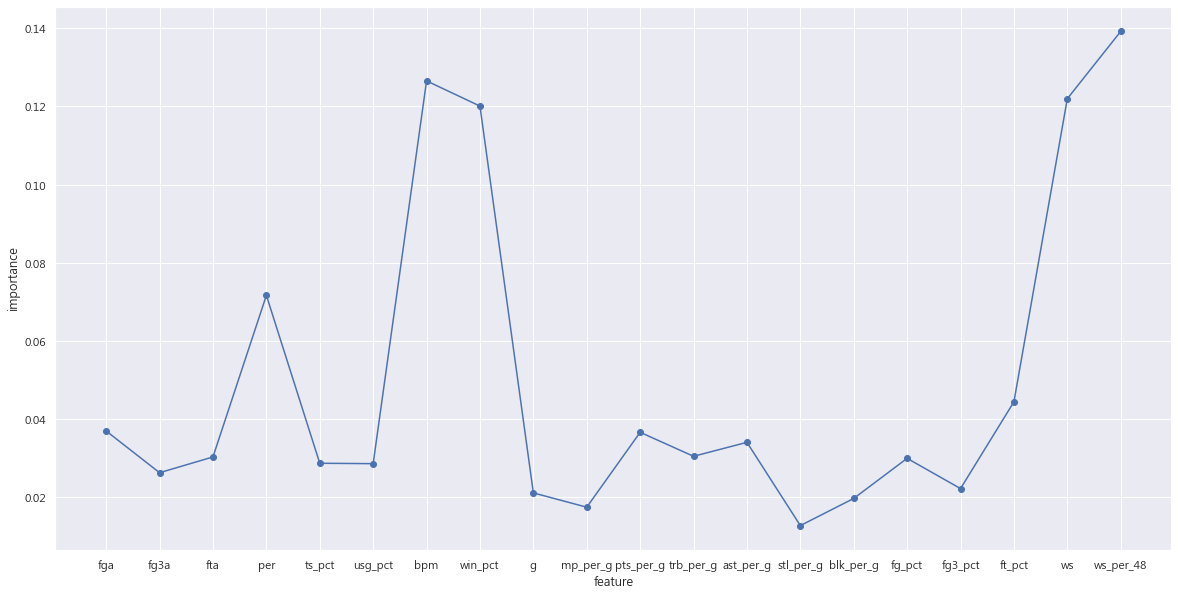

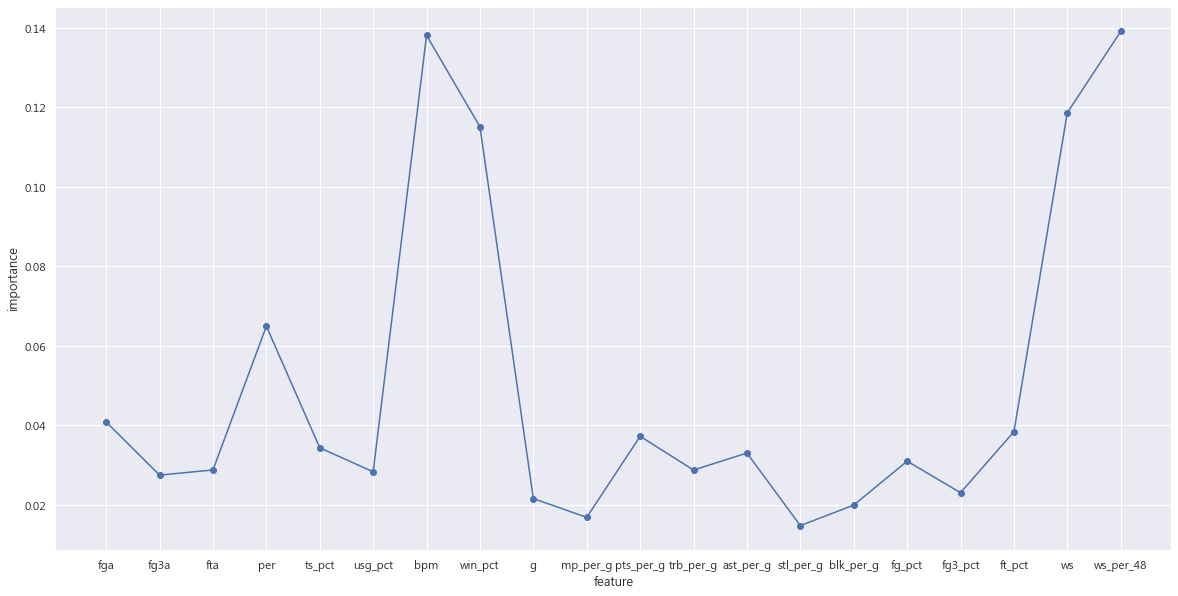

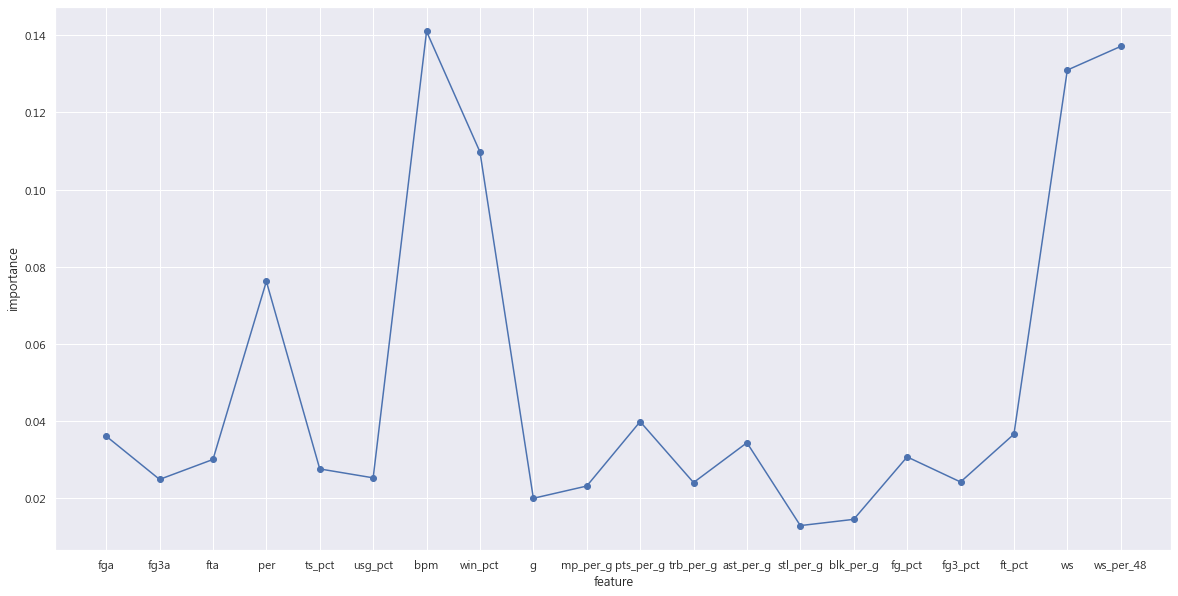

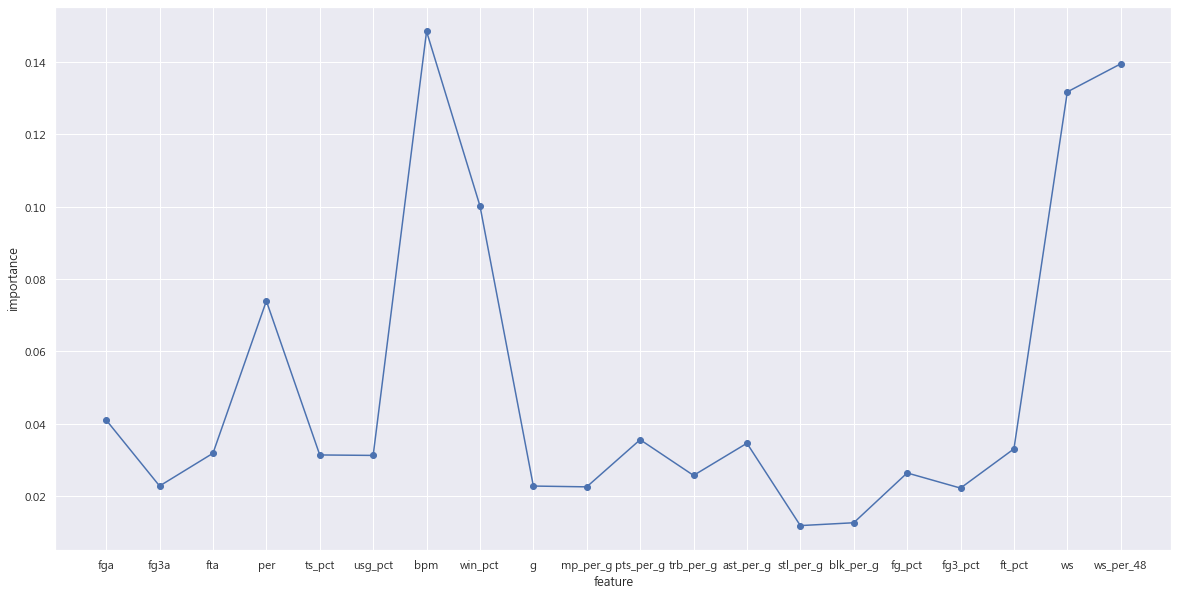

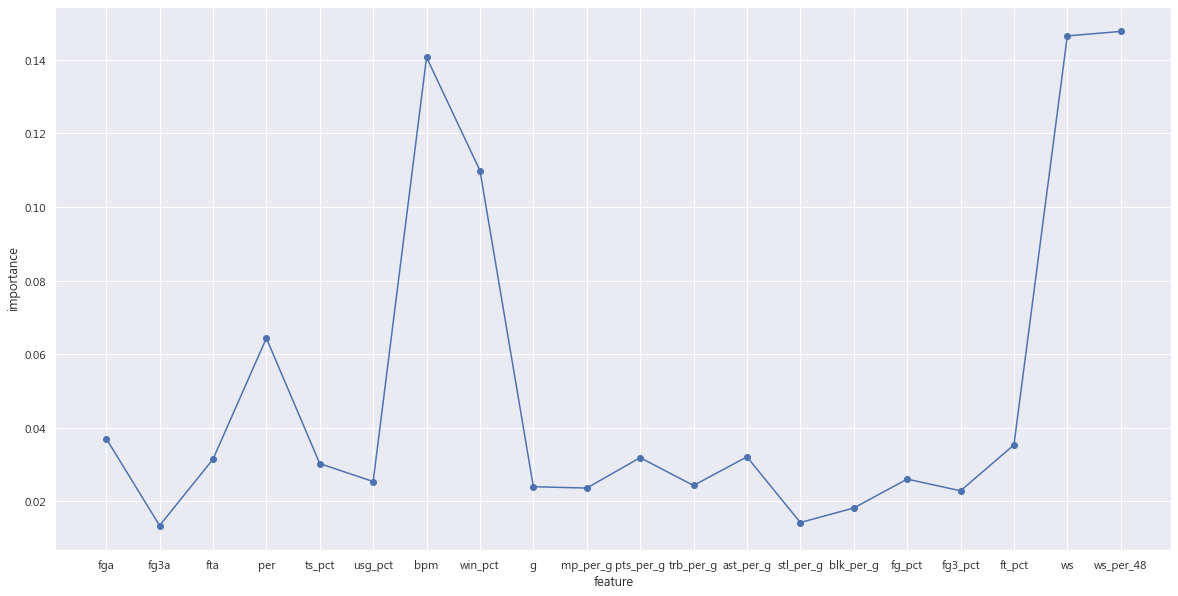

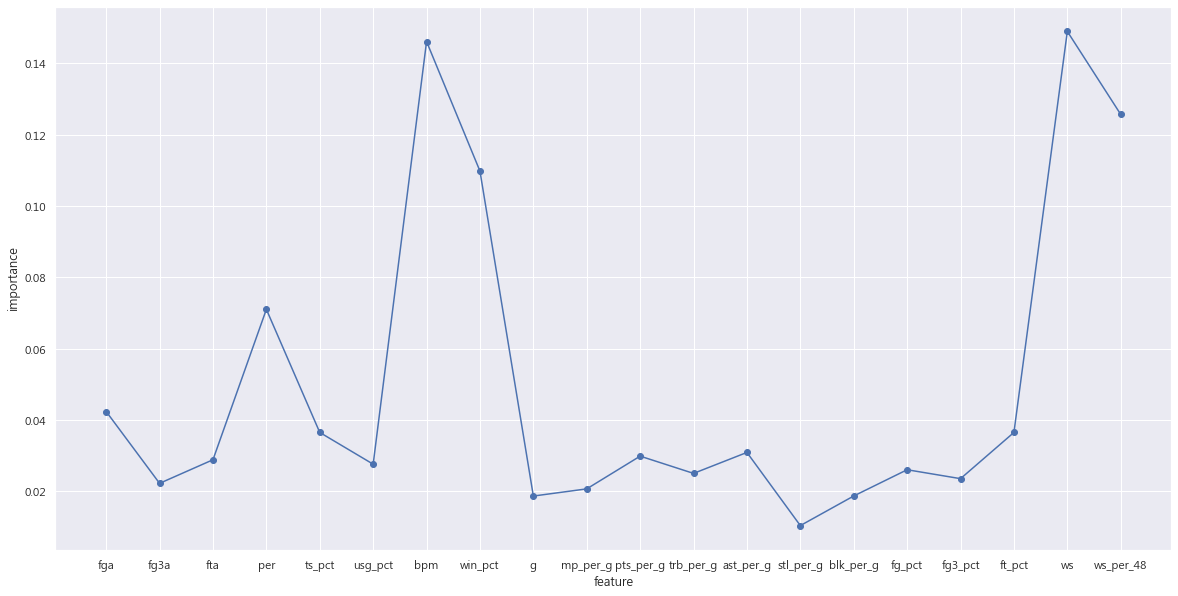

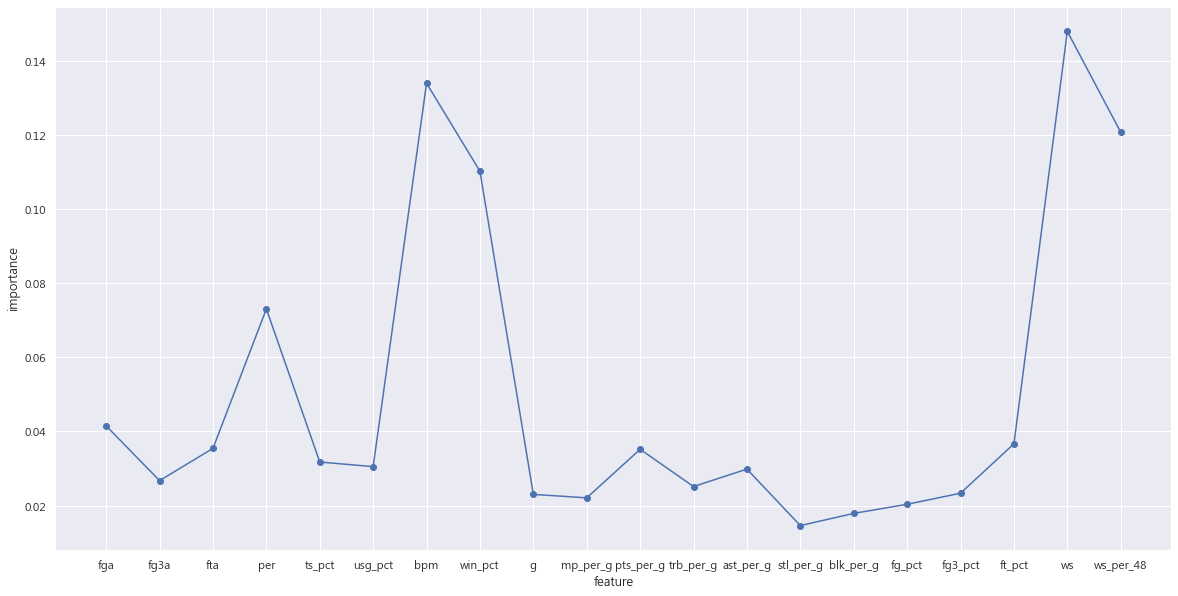

In [13]:
ac=[]
pr=[]
feature= np.zeros( (10,20) )
for i in range(1, 11): #0-10  
    X_train = pd.DataFrame(columns=MVP_ALL.columns)
    X_final_train = pd.DataFrame(columns=MVP_ALL.columns)
    X_final_test = pd.DataFrame(columns=MVP_ALL.columns)
    for j in range(1, (28+i)):
        X_train = X_train.append(MVP_ALL[MVP_ALL.season==j])
        
    X_final_test = X_final_test.append(MVP_ALL[MVP_ALL.season==(j+1)])  

    n=8      # 設定 抽樣數
    rs=10    # 設定 random seed 
    num = pd.unique(X_train.season)
    for k in range(len(num)):
        M_num = X_train[(X_train.season==num[k])&(X_train.MVP==1)]
        n_num = X_train[(X_train.season==num[k])&(X_train.MVP==0)]
        test_index=n_num.sample(n,random_state=rs) 
        X_final_train = pd.concat([X_final_train,M_num])
        X_final_train = pd.concat([X_final_train,test_index])
 
    Y_final_train = X_final_train.MVP.astype('int64')
    Y_final_test = X_final_test.MVP.astype('int64')
    X_final_train = X_final_train.drop(['season', 'player','MVP'],axis=1)
    X_final_test = X_final_test.drop(['season', 'player','MVP'],axis=1)
    
    RC = RandomForestClassifier(random_state=10,n_estimators = 100)  
    
    RC.fit(X_final_train,Y_final_train)

    expected = Y_final_test
    predicted = RC.predict(X_final_test)
   
    ac.append(RC.score(X_final_test, Y_final_test))
    pr.append(metrics.precision_score(expected, predicted, average='macro'))
    
    feat_label = X_final_train.columns
    fi = pd.DataFrame({'feature': list(feat_label),
                   'importance': RC.feature_importances_})

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.plot(fi.feature,fi.importance,marker='o')
    plt.xlabel("feature")
    plt.ylabel("importance")
    filename = i+27
    #plt.savefig('NBA/n8/'+str(filename)+'.png')#儲存圖片
    
    for l in range(0,20):
        feature[i-1,l]=fi.importance[l]
    
print("accuracy=",statistics.mean(ac),"precision=",statistics.mean(pr))    

[回本章目錄](#本章目錄)

### 將10次的特徵重要度"平均"做成曲線圖

In [14]:
pd_feature = pd.DataFrame(columns=X_final_train.columns)
pd_feature.loc[0]=0
for i in range(0,20):
    a=0
    for j in range(0,10):
        a=a+feature[j,i]
    pd_feature.iloc[0,i]=a/10

fi = pd.DataFrame({'feature': list(feat_label),
                   'importance': pd_feature.iloc[0]}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
bpm,bpm,0.140843
ws_per_48,ws_per_48,0.134263
ws,ws,0.13068
win_pct,win_pct,0.106542
per,per,0.0703696
ft_pct,ft_pct,0.0387227
fga,fga,0.0375093
pts_per_g,pts_per_g,0.0370098
ast_per_g,ast_per_g,0.0329921
fta,fta,0.0318747


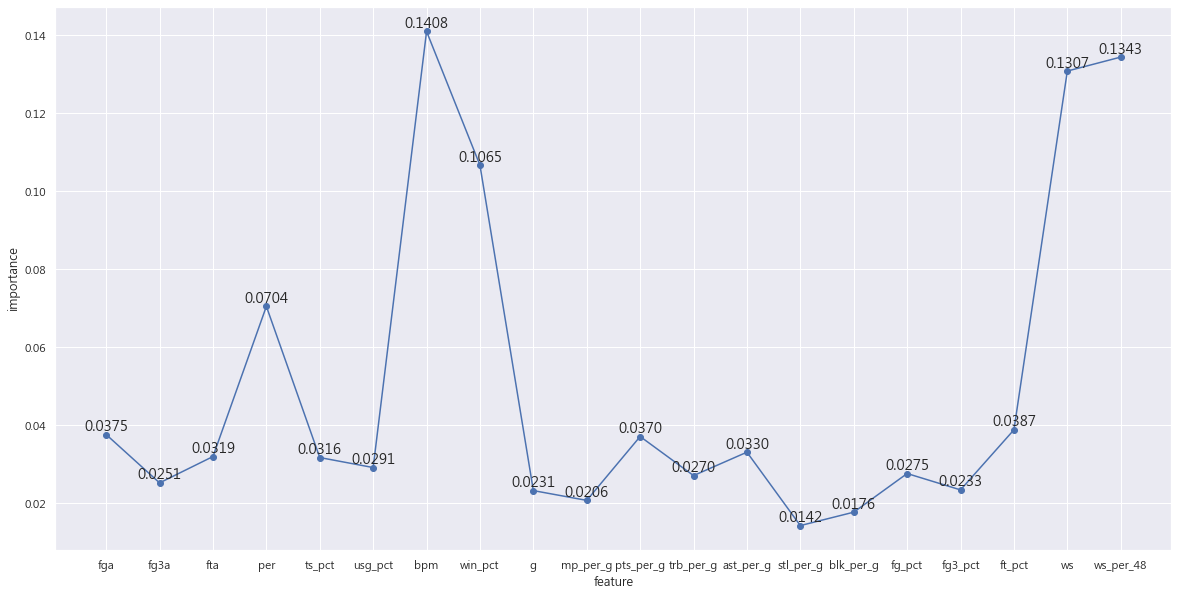

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pd_feature.columns,pd_feature.iloc[0],marker='o')
plt.xlabel("feature")
plt.ylabel("importance")
for a,b in zip(fi['feature'],fi['importance']):
    plt.text(a, b, '%.4f' % b, ha='center', va= 'bottom',fontsize=14)
# plt.savefig('NBA/n8/all.png')#儲存圖片

[回本章目錄](#本章目錄)

## 11. 訓練模型
### 使用最佳抽樣數n=8與較重要的特徵得到訓練集與測試集，以利訓練出最後的MODEL 
- <font style='font-weight:bold;color:red'>我們觀察了上面的特徵重要度平均曲線圖，使用了特徵重要度大於0.1、0.07、0.03等等的組合去訓練MODEL，當然我們也訓練了不挑選特徵的MODEL。</font>

In [18]:
n=8      # 設定 抽樣數
rs=10    # 設定 random seed 
num = pd.unique(MVP_ALL.season)
X_train = pd.DataFrame(columns=MVP_ALL.columns)
X_final_train = pd.DataFrame(columns=MVP_ALL.columns)
X_final_test = pd.DataFrame(columns=MVP_ALL.columns)
for k in range(len(num)-1):
    M_num = MVP_ALL[(MVP_ALL.season==num[k])&(MVP_ALL.MVP==1)]
    n_num = MVP_ALL[(MVP_ALL.season==num[k])&(MVP_ALL.MVP==0)]
    test_index=n_num.sample(n,random_state=rs) 
    X_final_train = pd.concat([X_final_train,M_num])
    X_final_train = pd.concat([X_final_train,test_index])


Y_final_train = X_final_train.MVP.astype('int64')
# X_final_train = X_final_train.drop(['season', 'player','MVP'],axis=1)  
X_final_train = X_final_train[['bpm','win_pct','ws','ws_per_48']]
# X_final_train = X_final_train[['per','bpm','win_pct','ws','ws_per_48']]
# X_final_train = X_final_train[['per','bpm','win_pct','ws','ws_per_48','ft_pct']]
# X_final_train = X_final_train[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga']]
# X_final_train = X_final_train[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g']]
# X_final_train = X_final_train[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g','ast_per_g','fta','ts_pct']]
    
X_final_test = MVP_ALL[MVP_ALL.season==39] 
Y_final_test = X_final_test.MVP.astype('int64')
Y_final_test[637] = 0
Y_final_test[638] = 1
# X_final_test = X_final_test.drop(['season', 'player','MVP'],axis=1)
X_final_test = X_final_test[['bpm','win_pct','ws','ws_per_48']]
# X_final_test = X_final_test[['per','bpm','win_pct','ws','ws_per_48']]
# X_final_test = X_final_test[['per','bpm','win_pct','ws','ws_per_48','ft_pct']]
# X_final_test = X_final_test[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga']]
# X_final_test = X_final_test[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g']]
# X_final_test = X_final_test[['per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g','ast_per_g','fta','ts_pct']]

### 取得RandomForestClassifier的最佳參數

In [19]:
RC = RandomForestClassifier(oob_score=True,random_state=10)
param_grid = {
                 'n_estimators': [5, 10, 15, 20,100,150,200,250,300,350],
                 'max_depth': [2, 5, 7, 9,10,15,20,25,30],
             }
grid_clf = GridSearchCV(RC, param_grid, cv=10)
grid_clf.fit(X_final_train,Y_final_train)
grid_clf.best_params_

{'max_depth': 15, 'n_estimators': 15}

[回本章目錄](#本章目錄)
### 訓練最後的MODEL

In [21]:
RC = RandomForestClassifier(oob_score=True,random_state=10,n_estimators=15,max_depth=15)
RC.fit(X_final_train,Y_final_train)

print("Test set accuracy: {:.6f}".format(RC.score(X_final_test, Y_final_test)))
print("Test set oob-score: {:.6f}".format(RC.oob_score_))

# 嘗試預測 x, y
expected = Y_final_test
predicted = RC.predict(X_final_test)

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

# 全部  oob-score: 0.926901  accuracy: 0.975000 全預測不是MVP
#4'bpm','win_pct','ws','ws_per_48'  oob-score: 0.944444 ,accuracy: 1.000000
#6'per','bpm','win_pct','ws','ws_per_48','ft_pct'  oob-score: 0.929825 ,accuracy: 0.950000 預測錯
#7'per','bpm','win_pct','ws','ws_per_48','ft_pct','fga'  oob-score: 0.935673 ,accuracy: 0.975000 兩個MVP
#8'per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g'  oob-score: 0.926901 ,accuracy: 0.975000 兩個MVP
#11'per','bpm','win_pct','ws','ws_per_48','ft_pct','fga','pts_per_g','ast_per_g','fta','ts_pct' oob-score: 0.935673 ,accuracy: 1


Test set accuracy: 1.000000
Test set oob-score: 0.944444
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00         1

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

[[39  0]
 [ 0  1]]


[回本章目錄](#本章目錄)
### 不同的特徵訓練MODEL後的OOB score評估

<img src="./Data and image/OOB.png" width="800"/>

- 依照上述我們認為使用特徵重要度大於0.1的特徵訓練出來的MODEL效果是最好的。

## 12. 預測結果

In [22]:
RC.predict(X_final_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

<img src="./Data and image/mvp.png" width="800"/>

- 最後MODEL所預測的2019年的MVP為Giannis Antetokounmpo 字母哥，與當年的MVP相符。

# 最後我們將樹給output出來並存在PDF檔裡

In [28]:
Estimators = RC.estimators_
for index, model in enumerate(Estimators):
    filename = 'NBA_tree/NBA_' + str(index) + '.pdf'
    dot_data = export_graphviz(model , out_file=None,
                         feature_names=list(X_final_train.columns),
                         class_names=['1','0'],
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    graph.write_pdf(filename)

[回本章目錄](#本章目錄)